In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, output_size=1, num_style_classes=24):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Real/fake head
        self.real_fake_head = nn.Sequential(
            nn.Conv2d(ndf * 8, output_size, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        real_fake_output = self.real_fake_head(x)
        return real_fake_output.view(-1, 1)

torch.Size([2, 3, 64, 64])
torch.Size([2, 1])


In [ ]:
generator_baseline_110 = Generator()
checkpoint_baseline_110 = torch.load('/content/drive/MyDrive/cv2/scaled_baseline_bs_128_epoch_120.pt', map_location=torch.device('cpu'))
generator_baseline_110.load_state_dict(checkpoint_baseline_110['netG'])


generator_creative_110 = Generator()
checkpoint_creative_110 = torch.load('/content/drive/MyDrive/cv2/scaled_creative_bs_128_epoch_110.pt', map_location=torch.device('cpu'))
generator_creative_110.load_state_dict(checkpoint_creative_110['netG'])

<All keys matched successfully>

In [ ]:
def get_fixed_gen_images(generators, epoch_labels, rows=6):
    latent_vectors = []
    images = []
    k = 0
    for j in range(rows):
        for i in range(len(generators)):
            mean = 0.0
            std_dev = 0.5

            normal_distribution = torch.distributions.normal.Normal(mean, std_dev)

            fixed = normal_distribution.sample((1, 100, 1, 1)).to(torch.device('cpu'))
            # fixed = torch.randn(1, 100, 1, 1).to(torch.device('cpu'))

            fixed = fixed.detach()
            style_label = torch.tensor([j]).view(-1).to(torch.device('cpu')).detach()
            normalized_output = generators[i](fixed)
            reverse_transform = transforms.Compose([
                # transforms.Normalize((-1, -1, -1), (2, 2, 2)),
            ])
            out = (reverse_transform(normalized_output) * 255).detach().cpu().numpy()
            out = out.astype(np.uint8)
            out = out.squeeze(0)
            image = Image.fromarray(out.transpose(1, 2, 0), 'RGB')
            images.append(image)
    return images

(-0.5, 639.5, 639.5, -0.5)

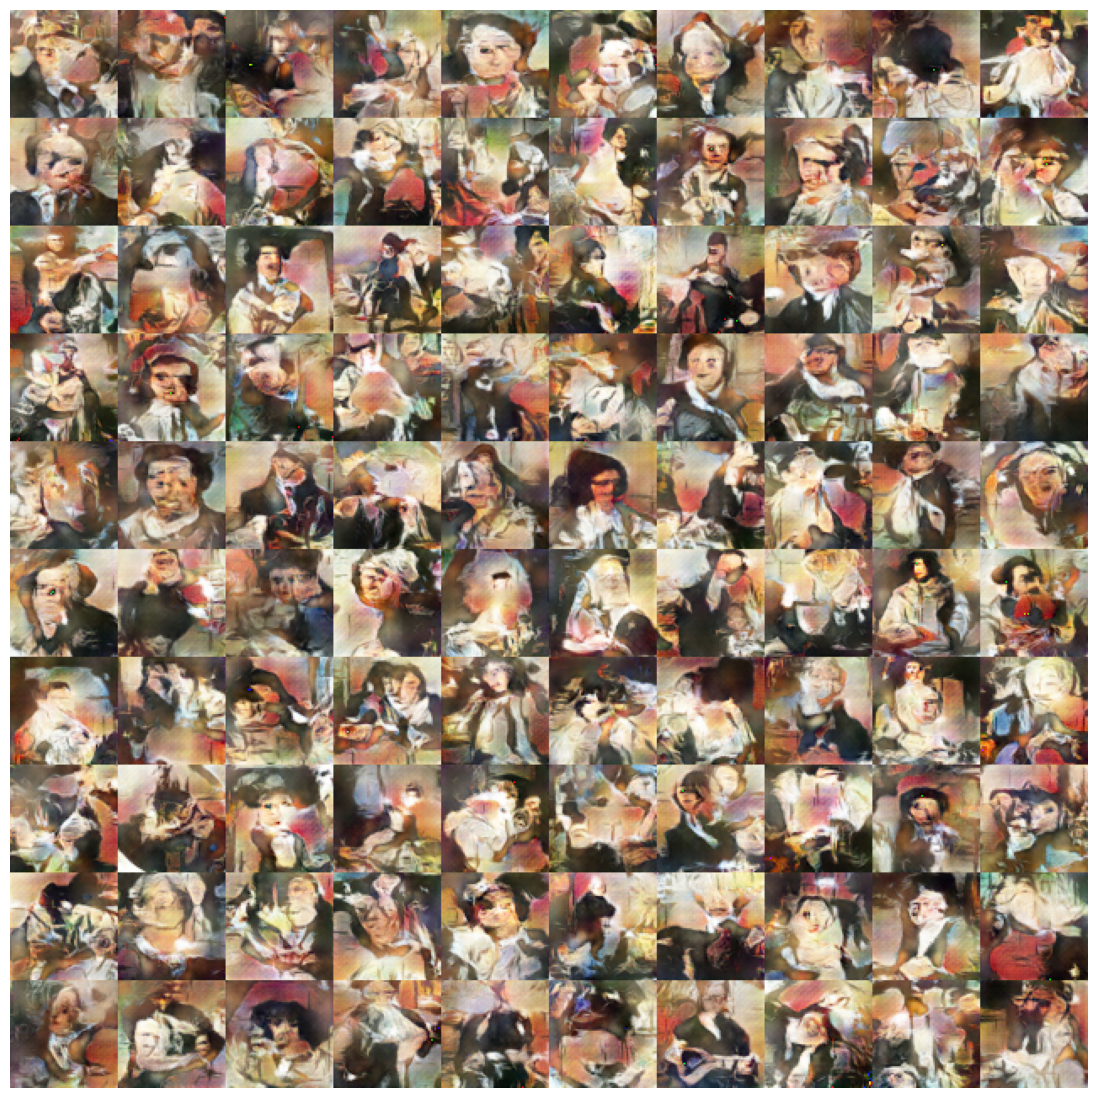

In [ ]:
images = get_fixed_gen_images([generator_baseline_110]*10, ['110 Creative']*10, rows = 10)
# Convert PIL images to numpy arrays
image_arrays = [np.array(img) for img in images]

# Create a collage by concatenating images horizontally and vertically
rows = []
for i in range(0, len(image_arrays), 10):
    row = np.concatenate(image_arrays[i:i+10], axis=1)
    rows.append(row)
collage = np.concatenate(rows, axis=0)


plt.figure(figsize=(14, 14))
# Display the collage
plt.imshow(collage)
plt.axis('off')  # Turn off axis labels

(-0.5, 639.5, 639.5, -0.5)

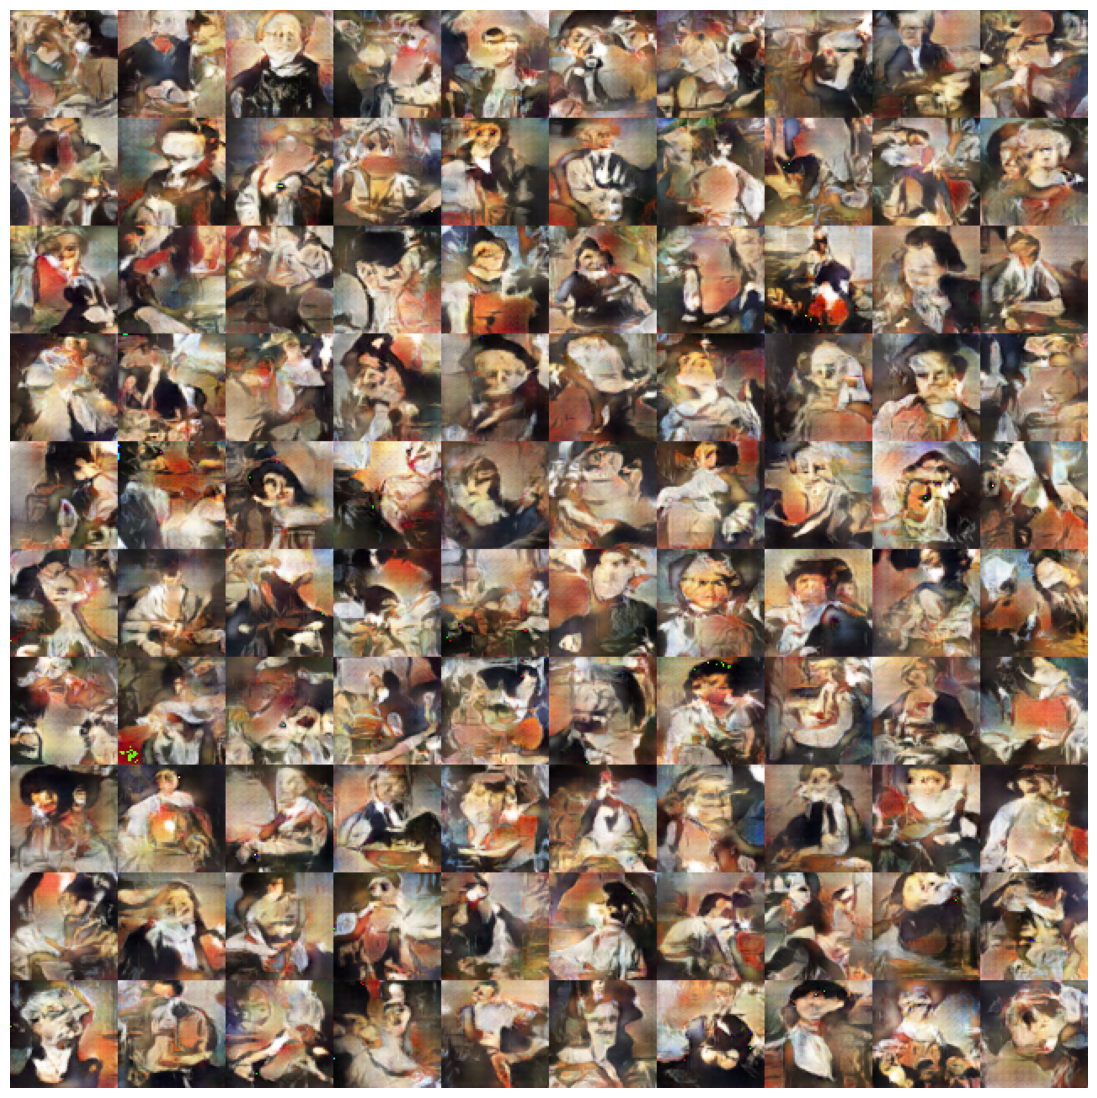

In [ ]:
images = get_fixed_gen_images([generator_creative_110]*10, ['110 Creative']*10, rows = 10)
# Convert PIL images to numpy arrays
image_arrays = [np.array(img) for img in images]

# Create a collage by concatenating images horizontally and vertically
rows = []
for i in range(0, len(image_arrays), 10):
    row = np.concatenate(image_arrays[i:i+10], axis=1)
    rows.append(row)
collage = np.concatenate(rows, axis=0)


plt.figure(figsize=(14, 14))
# Display the collage
plt.imshow(collage)
plt.axis('off')  # Turn off axis labels

In [5]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3, num_style_classes=24):
        super(Generator, self).__init__()
        self.num_style_classes = num_style_classes
        self.style_embedding = nn.Embedding(num_style_classes, nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input, style_label):
        style_emb = self.style_embedding(style_label)
        style_emb = style_emb.unsqueeze(2).unsqueeze(3).expand(-1, -1, input.size(2), input.size(3))
        input = torch.cat([input, style_emb], dim=1)
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, output_size=1, num_style_classes=24):
        super(Discriminator, self).__init__()
        self.num_style_classes = num_style_classes
        self.style_embedding = nn.Embedding(num_style_classes, nc)
        self.main = nn.Sequential(
            nn.Conv2d(nc + nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Real-fake head
        self.real_fake_head = nn.Sequential(
            nn.Conv2d(ndf * 8, output_size, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        # Multi-label head
        self.multi_label_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8192, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, num_style_classes),
            nn.Softmax()
        )

    def forward(self, x, style_label):
        style_emb = self.style_embedding(style_label)
        style_emb = style_emb.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, style_emb], dim=1)
        x = self.main(x)
        real_fake_output = self.real_fake_head(x)
        multi_label_output = self.multi_label_head(x)
        return real_fake_output.view(-1, 1), multi_label_output


In [6]:
generator_120_condcreate = Generator()
checkpoint_120_condcreate = torch.load('/content/drive/MyDrive/cv2/Copy of scaled_condcreative_bs_128_epoch_120.pt', map_location=torch.device('cpu'))
generator_120_condcreate.load_state_dict(checkpoint_120_condcreate['netG'])

<All keys matched successfully>

In [19]:
def get_fixed_gen_images_label(generators, epoch_labels, rows=6):
    if rows > 24:
        rows = 24
    latent_vectors = []
    # fig, ax = plt.subplots(rows, len(generators), figsize=(50, 50))
    # fig.subplots_adjust(wspace=0, hspace=0.5)  # Set spacing between subplots
    images = []
    k = 0
    for j in range(rows):
        for i in range(len(generators)):
            fixed = torch.randn(1, 100, 1, 1).to(torch.device('cpu'))
            fixed = fixed.detach()
            style_label = torch.tensor([j]).view(-1).to(torch.device('cpu')).detach()
            normalized_output = generators[i](fixed, style_label)
            reverse_transform = transforms.Compose([
                transforms.Normalize((-1, -1, -1), (2, 2, 2)),
            ])
            out = (reverse_transform(normalized_output) * 255).detach().cpu().numpy()
            out = out.astype(np.uint8)
            out = out.squeeze(0)
            image = Image.fromarray(out.transpose(1, 2, 0), 'RGB')
            images.append((image, j))
    return images

(-0.5, 639.5, 639.5, -0.5)

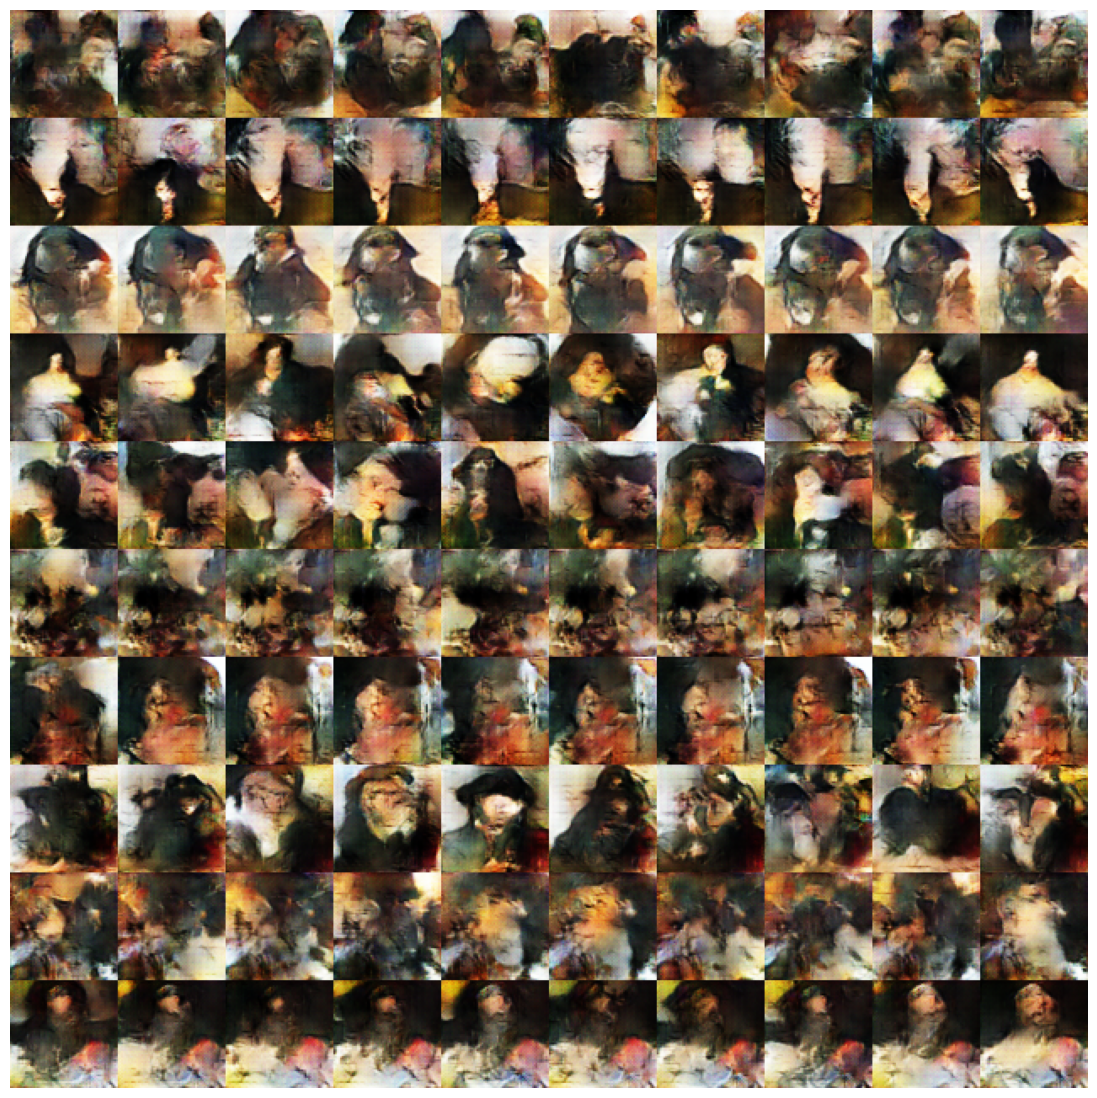

In [20]:
images = get_fixed_gen_images_label([generator_120_condcreate]*10, ['110 Creative']*10, rows = 10)
# Convert PIL images to numpy arrays
image_arrays = [np.array(img) for (img, label) in images]

# Create a collage by concatenating images horizontally and vertically
rows = []
for i in range(0, len(image_arrays), 10):
    row = np.concatenate(image_arrays[i:i+10], axis=1)
    rows.append(row)
collage = np.concatenate(rows, axis=0)


plt.figure(figsize=(14, 14))
# Display the collage
plt.imshow(collage)
plt.axis('off')  # Turn off axis labels